In [2]:
from collections import Counter
import string

from gensim.models import Doc2Vec
import time

from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import TaggedDocument
from nltk import word_tokenize

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
import numpy as np

from sklearn.manifold import TSNE
import itertools

from itertools import combinations
import csv

import re
import string
import pandas as pd

# Load and Downsample Data

In [3]:
# NPR correspondent/reporter archive links
urls = [
    'https://www.npr.org/people/1931801/linda-wertheimer/archive',
    'https://www.npr.org/people/2101212/lakshmi-singh/archive',
    'https://www.npr.org/people/467974737/brett-neely/archive',
    'https://www.npr.org/people/2100955/patti-neighmond/archive',
    'https://www.npr.org/people/392602474/domenico-montanaro/archive',
    'https://www.npr.org/people/1936301/john-burnett/archive',
    'https://www.npr.org/people/348780034/nicole-cohen/archive',
    'https://www.npr.org/people/349241810/rose-friedman/archive',
        
    'https://www.npr.org/people/2100689/christopher-joyce/archive',
    'https://www.npr.org/people/384067907/rebecca-hersher/archive',
         
   'https://www.npr.org/people/468930062/jane-greenhalgh/archive',

   'https://www.npr.org/people/536711382/gisele-grayson/archive',
   'https://www.npr.org/people/578890280/rhitu-chatterjee/archive',

   'https://www.npr.org/people/348730771/aarti-shahani/archive',
   'https://www.npr.org/people/676406186/sacha-pfeiffer/archive',
   'https://www.npr.org/people/96022165/yuki-noguchi/archive',
   'https://www.npr.org/people/131724812/scott-neuman/archive',

   'https://www.npr.org/people/448294256/sarah-mccammon/archive',
   'https://www.npr.org/people/2100815/jennifer-ludden/archive',
   'https://www.npr.org/people/122805042/tamara-keith/archive',
   'https://www.npr.org/people/2100569/richard-gonzales/archive',

    'https://www.npr.org/people/5201175/michel-martin/archive',
    'https://www.npr.org/people/2100615/jon-hamilton/archive',
    'https://www.npr.org/people/2101154/ari-shapiro/archive'
    'https://www.npr.org/people/2100438/debbie-elliott/archive',
    'https://www.npr.org/people/348778932/michaeleen-doucleff/archive',
    'https://www.npr.org/people/7569853/russell-lewis/archive',
    'https://www.npr.org/people/348766539/greg-myre/archive',
    'https://www.npr.org/people/473143808/alison-kodjak/archive', 
    'https://www.npr.org/people/2788801/scott-horsley/archive',
    'https://www.npr.org/people/2100631/richard-harris/archive',
    'https://www.npr.org/people/146944972/rob-stein/archive',
    'https://www.npr.org/people/544275644/ryan-lucas/archive',
    'https://www.npr.org/people/2101062/philip-reeves/archive',
    'https://www.npr.org/people/279612138/geoff-brumfiel/archive',
    'https://www.npr.org/people/1930203/ron-elving/archive',
    'https://www.npr.org/people/2100569/richard-gonzales/archive']

names = []
for url in urls:
    names.append(url.split('/')[5].replace('-', ' '))

In [4]:
# Create list of reporter names
reporters = [name.split()[1].upper() for name in names]

In [5]:
npr_bystory_df = pd.read_csv('npr_df.csv')

In [6]:
# Group news pieces by speaker
grps = npr_bystory_df[npr_bystory_df['speaker'].isin(reporters)].groupby('speaker')

# A list of the speakers who have more than sample_size articles
full_article_speakers = []

sample_size = 120
culled_npr_bystory = []
for grp in grps:
    if len(grp[1])>sample_size:
        culled_npr_bystory.append(grp[1].sample(n=sample_size))
        print(grp[0], len(grp[1]))
        full_article_speakers.append(grp[0])

BRUMFIEL 166
BURNETT 440
ELVING 280
GONZALES 293
HAMILTON 361
HARRIS 479
HORSLEY 744
JOYCE 399
KEITH 709
KODJAK 128
LUDDEN 333
MARTIN 186
MCCAMMON 237
MONTANARO 152
NEIGHMOND 255
NOGUCHI 446
REEVES 605
SHAHANI 199
SHAPIRO 638
STEIN 224
WERTHEIMER 266


In [7]:
# Create dataframe of sample_size number of articles for each reporter
culled_npr_bystory_df = pd.concat(culled_npr_bystory)

In [13]:
culled_npr_bystory_df= culled_npr_bystory_df.drop(['Unnamed: 0'],  axis=1)

# Functions

## Doc2Vec Representation

In [28]:
# Takes tagged vectors and a set of parameters and trains a doc2vec model
def train_model(tagged_vects, params):
    max_epochs = 200

    model = Doc2Vec(**params)

    model.build_vocab(tagged_vects)

    t1 = time.time()
    for epoch in range(max_epochs):
        model.train(tagged_vects, total_examples = model.corpus_count, epochs = model.iter)
        model.alpha -= .0001
        model.min_alpha = model.alpha

    t2 = time.time()
    print('Time: {}'.format(t2-t1))
    return model

In [15]:
# Returns doc2vec modelled vectors
def make_d2v_df(model, tagged_vects):
    return pd.DataFrame([model.docvecs[ik] for ik in range(len(tagged_vects))])

## Clustering

In [16]:
# Clusters document vectors with a range of k values and returns scores, and models
def make_clusters(doc_vecs_df, **kwargs):
    nclusts = []
    sscores = [] 
    avg_obs = []
    obs_std = []
    models = []
    labels = []
    
    if 'max_clusters' in kwargs:
        max_clusters = kwargs['max_clusters']
    else:
        max_clusters = 40
        
    for no in range(2,max_clusters,1):
        t1 = time.time()
        model = KMeans(n_clusters=no, random_state=43).fit(doc_vecs_df)
        fdv_clusters = model.predict(doc_vecs_df)
        nclusts.append(no)
        sscores.append(silhouette_score(doc_vecs_df, fdv_clusters, metric='cosine'))
        avg_obs.append(pd.value_counts(fdv_clusters).mean())
        obs_std.append(pd.value_counts(fdv_clusters).std())
        models.append(model)
        labels.append(fdv_clusters)
        
    return models, pd.DataFrame({'nclusts':nclusts, 'sscores':sscores, 'avg_obs':avg_obs, 'obs_std':obs_std})

In [17]:
# Visualize clustering overall as sil plots
def make_sil_plot(df, **kwargs):
    obsstd1 = [ i+j for i,j in zip(df['avg_obs'],df['obs_std'])]
    stdneg = [ i-j for i,j in zip(df['avg_obs'],df['obs_std'])]

    fig, ax = fig, ax = plt.subplots(figsize=(6,4))

    ax2 = ax.twinx()
    ax = sns.lineplot(df['nclusts'], df['sscores'],color='g', label='Sil. Score', linewidth=2, ax=ax)
    ax2 =sns.lineplot(df['nclusts'], df['avg_obs'],color='purple',label='Avg obs per cluster', linewidth=2)
    sns.lineplot(df['nclusts'],obsstd1,color='r',label='+/- Std Avg Obs', linewidth=.6)
    sns.lineplot(df['nclusts'],stdneg,color='r', linewidth=.6)

    ax.set_ylabel('Sil. Score')
    ax.set_xlabel('Number of Clusters')
    ax.axvline(x=df['nclusts'].iloc[df['sscores'].argmax()],color='r',linestyle='dotted')

    ax.legend(loc='lower left')
    ax2.legend(loc='upper right')
    plt.ylabel('Average Observation per cluster')
    plt.xlabel('Number of Clusters')
    plt.title('Silhouette Scores by Number of Clusters',fontsize=20)

    if 'save_name' in kwargs:
        plt.savefig(kwargs['save_name'], format='svg', bbox_inches='tight')

In [18]:
# Build TSNE axes from vectors for cluster viz
def fit_tsne(num_clusters, d2v_vecs_df,X_train, **kwargs):
    tsne = TSNE(n_components=2, random_state=43)
    
    #create dataframe for plotting, add components,labels
    tsne_plot_df = pd.DataFrame()
    tsne_plot_df['original'] = X_train['cleaned_text']
    tsne_plot_df['ids'] = X_train['ids']

    #get cluster assignments from KMeans
    if ('assigned_labels' in kwargs):
        d2v_clusterst = kwargs['assigned_labels']
    else:
        d2v_clusterst = KMeans(n_clusters=num_clusters, random_state=43).fit_predict(d2v_vecs_df)

    tsne_plot_df['clusters'] = d2v_clusterst

    #fit transform doc2vec word vectors
    Yt = tsne.fit_transform(d2v_vecs_df)
    tsne_plot_df['TSNE_1'] = Yt[:,0]
    tsne_plot_df['TSNE_2'] = Yt[:,1]
    return tsne_plot_df

In [19]:
# Produce TSNE plot
def make_tsne_plot(tsne_plot_df, num_clusters, **kwargs):
    plt.figure(figsize=(6,5))
    sns.despine(left=True)

    sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='clusters', data=tsne_plot_df, palette='BrBG', legend='full',
                    edgecolor='black', s=40, alpha=.7).set_title('KMeans {} clusters'.format(num_clusters))

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlim([tsne_plot_df['TSNE_1'].min()*1.2, tsne_plot_df['TSNE_1'].max()*1.2])
    plt.ylim([tsne_plot_df['TSNE_2'].min()*1.2, tsne_plot_df['TSNE_2'].max()*1.2])
    
    if 'save_name' in kwargs:
        plt.savefig(kwargs['save_name'], format='svg', bbox_inches='tight')


# Model Tuning

In [ ]:
# Exhaustively search the parameter space for best doc2vec parameters
params = {'vector_size' : 200, 'alpha' : .025, 'min_alpha' : .0001, 'min_count' : 7, 'dm' :1, 'window':0, 'negative':0}

param_lst = []
scores = []
clusters = []

min_alpha_range = list(np.arange(.0001,.0004,.01))
alpha_range = [.02]#list(np.arange(.01,.04,.01))
min_count_range = [10]#list(range(10,16,2))
vector_size_range = list(range(20,50,10))
negative_range = [1]#list(range(1,2))
window_range = [3]#list(range(3,6))
dm_range = [1]

for ik, tple in enumerate(itertools.product(min_alpha_range, alpha_range, min_count_range, vector_size_range, negative_range, window_range,dm_range)):
    for im, key in enumerate(['min_alpha', 'alpha', 'min_count', 'vector_size', 'negative', 'window', 'dm']):
        params[key] = tple[im]
    param_lst.append([tagged,params.copy()])

print('total number of combinations:', ik+1)
for lst in param_lst:
    tagged, params = lst[0], lst[1]
    model = train_model(tagged, params)
    d2v_vecs = make_d2v_df(model, tagged)
    kmeans_mdls, df_clusters = make_clusters(d2v_vecs)
    scores.append(max(df_clusters['sscores']))
    num_clusters = df_clusters['nclusts'].iloc[df_clusters['sscores'].idxmax()]
    clusters.append(num_clusters)
    print(ik, max(df_clusters['sscores']),num_clusters, '\n')
#     d = {'num_clusters': num_clusters, 'score': max(df_clusters['sscores']), 'params': params}



In [ ]:
# Using identified parameters, exhaustively search the reporter combinations
# looking for a set of reporters that best describe the news space and print
# results to csv.
#
# N.B. Can't use multiprocessing because of how Doc2Vec runs.

params = {'vector_size': 20, 'alpha': 0.02, 'min_alpha': 0.0001, 'min_count': 10, 'dm': 1, 'window': 3, 'negative': 1}

speaker_lists = list(combinations(full_article_speakers, 10))

with open('npr_d2v_rep_comb.csv4', 'w') as csvfile:
    for ik, speaker_list in enumerate(speaker_lists[193:]):
        X_train, X_test = train_test_split(culled_npr_bystory_df[culled_npr_bystory_df['speaker'].isin(speaker_list)])

        X_train = pd.DataFrame(X_train, columns = culled_npr_bystory_df.columns)
        X_test = pd.DataFrame(X_test, columns = culled_npr_bystory_df.columns)

        tagged = [TaggedDocument(words = word_tokenize(comment.lower()), tags = [str(ik)]) for  ik, comment in enumerate(X_train['cleaned_text'])]

        model = train_model(tagged, params)
        d2v_vecs = make_d2v_df(model, tagged)
        kmeans_mdls, df_clusters = make_clusters(d2v_vecs)

        num_clusters = df_clusters['nclusts'].iloc[df_clusters['sscores'].idxmax()]
        row = [df_clusters['sscores'].max(), num_clusters]+ list(speaker_list)
        csv.writer(csvfile).writerow(row)
        
#         print('score:', df_clusters['sscores'].max(), 'number of clusters:', num_clusters)
        print(speaker_list)


# Analysis

## Load & Prep Data

In [23]:
# Load csv of exhaustive search
df_dv = pd.read_csv('npr_d2v_rep_comb.csv')
df_dv.columns = ['score', 'clusters'] + ['reporter'+str(ik) for ik in range(1,11)]


### Choose Speaker Set

In [24]:
# order by score
top_dv = df_dv.sort_values(by = 'score', ascending=False)

In [25]:
# choose speaker list to look at
ik = 0
speaker_list = top_dv.iloc[ik, ~top_dv.columns.isin(['score, clusters'])]

### Split train and test sets

In [26]:
X_train, X_test = train_test_split(culled_npr_bystory_df[culled_npr_bystory_df['speaker'].isin(speaker_list)])
X_train = pd.DataFrame(X_train, columns = culled_npr_bystory_df.columns)
X_test = pd.DataFrame(X_test, columns = culled_npr_bystory_df.columns)
   
y_train = X_train['speaker']
y_test = X_test['speaker']

### Build Doc2Vec representations

In [29]:
tagged_X_train = [TaggedDocument(words = word_tokenize(comment.lower()), tags = [str(ik)]) for  ik, comment in enumerate(X_train['cleaned_text'])]
tagged_X_test = [TaggedDocument(words = word_tokenize(comment.lower()), tags = [str(ik)]) for  ik, comment in enumerate(X_test['cleaned_text'])]

model = train_model(tagged_X_train, params)
d2v_vecs_X_train = make_d2v_df(model, tagged_X_train)
d2v_vecs_X_test = make_d2v_df(model, tagged_X_test)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  # This is added back by InteractiveShellApp.init_path()


Time: 99.41647624969482


## Cluster

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  app.launch_new_instance()


score: 0.1974649946669836 number of clusters: 2


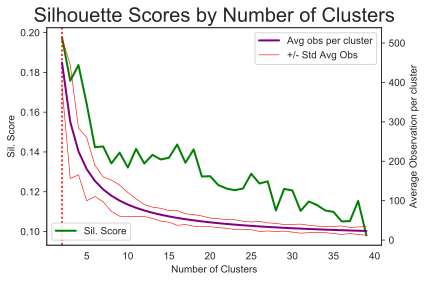

In [30]:
kmeans_mdls, df_clusters = make_clusters(d2v_vecs_X_train)
make_sil_plot(df_clusters, save_name = 'silplot_run_d2v_summary'+str(ik)+'.svg')
    
num_clusters = df_clusters['nclusts'].iloc[df_clusters['sscores'].idxmax()]
    
kmean_labels = kmeans_mdls[df_clusters['sscores'].idxmax()].predict(d2v_vecs_X_train.iloc[:, ~d2v_vecs_X_train.columns.isin(['labels', 'speaker', 'title', 'labels_sub'])])

print('score:', df_clusters['sscores'].max(), 'number of clusters:', num_clusters)

### Plot with TSNE

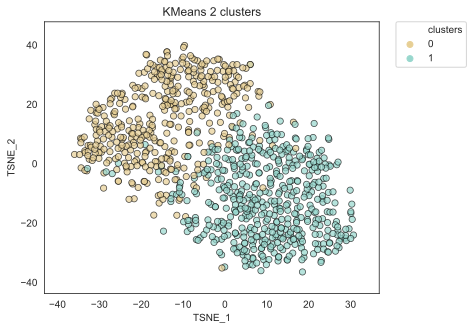

In [31]:
tsne_plot_df = fit_tsne(num_clusters, d2v_vecs_X_train.iloc[:, ~d2v_vecs_X_train.columns.isin(['labels', 'speaker', 'title', 'labels_sub'])],X_train.iloc[:, ~X_train.columns.isin(['labels', 'speaker'])], assigned_labels = kmean_labels)
make_tsne_plot(tsne_plot_df, num_clusters)#, save_name = 'tsne_kmeans_bestreps_'+str(ik)+'_'+str(num_clusters)+'.svg')


### Analyze Clusters

In [34]:
X_train['labels'] = kmeans_mdls[num_clusters-2].predict(d2v_vecs_X_train.iloc[:, ~d2v_vecs_X_train.columns.isin(['labels_sub','labels', 'speaker','title'])])#kmeans_mdls[7]#kmeans_mdl#
d2v_vecs_X_train['labels'] = kmeans_mdls[num_clusters-2].predict(d2v_vecs_X_train.iloc[:, ~d2v_vecs_X_train.columns.isin(['labels_sub','labels', 'speaker','title'])])

d2v_vecs_X_train['speaker'] = X_train['speaker'].values
d2v_vecs_X_train['title'] = X_train['title'].values

label_grps = d2v_vecs_X_train.groupby('labels')
for grp in label_grps:
    print( grp[0], len(grp[1]))
    speaker_groups = grp[1].groupby('speaker')
    for grp2 in speaker_groups:
        print(grp2[0], len(grp2[1]))
    print('\n')

0 405
BRUMFIEL 80
BURNETT 6
GONZALES 6
HAMILTON 88
HARRIS 72
HORSLEY 1
JOYCE 70
STEIN 82


1 495
BRUMFIEL 16
BURNETT 80
ELVING 87
GONZALES 81
HAMILTON 4
HARRIS 15
HORSLEY 89
JOYCE 18
KEITH 100
STEIN 5




### Clustering Clusters

In [35]:
split_labels = []
d = {}
score_to_beat = df_clusters['sscores'].max()
for ik, grp in enumerate(label_grps):
    tmp_df = grp[1].iloc[:, ~grp[1].columns.isin(['labels', 'speaker', 'title', 'labels_sub'])]
    kmeans_mdls2, df_clusters2 = make_clusters(tmp_df, max_clusters = 8)
    num_clusters2 = df_clusters2['nclusts'].iloc[df_clusters2['sscores'].idxmax()]
    
    # adding sub-label if cluster scored well
    if df_clusters2['sscores'].max()>score_to_beat:
        preds = kmeans_mdls2[df_clusters2['sscores'].idxmax()].predict(tmp_df)
        new_labels = [(ik+1)*100 + im for im in preds]
    else:
        new_labels = [(ik+1)*100 for im in grp[1]['labels']]
    for ip, im in enumerate(tmp_df.index):
        d[im] = new_labels[ip]
        
    # print summary information
    print('cluster:', grp[0], 'size:', len(grp[1]))
    print(max(df_clusters2['sscores']),num_clusters2, '\n')
    speaker_groups = grp[1].groupby('speaker')
    for grp2 in speaker_groups:
        print(grp2[0], len(grp2[1]))
    print('\n')
    
# consolidate new labels    
split_labels = [d[ik] for ik in range(len(d.keys()))]
conv_d = {key:ik for ik, key in enumerate(list(set(split_labels)))}
new_labels = [conv_d[label] for label in split_labels]

d2v_vecs_X_train['labels_sub'] = new_labels

# report on new clusters
labels_grps = d2v_vecs_X_train.groupby('labels')
for grp0 in labels_grps:
    print('cluster:', grp0[0], 'size:', len(grp0[1]))
    labels_sub_grps2 = grp0[1].groupby('labels_sub')
    for grp in labels_sub_grps2:
        print('subcluster:', grp[0], 'size:', len(grp[1]))
        speaker_groups = grp[1].groupby('speaker')
        for grp2 in speaker_groups:
            print('speaker:', grp2[0], 'number of articles:', len(grp2[1]))
            print(grp2[1][['speaker', 'title']])
        print('\n')
    print('\n')   


cluster: 0 size: 405
0.20341565885462493 2 

BRUMFIEL 80
BURNETT 6
GONZALES 6
HAMILTON 88
HARRIS 72
HORSLEY 1
JOYCE 70
STEIN 82


cluster: 1 size: 495
0.18594425416058746 2 

BRUMFIEL 16
BURNETT 80
ELVING 87
GONZALES 81
HAMILTON 4
HARRIS 15
HORSLEY 89
JOYCE 18
KEITH 100
STEIN 5


cluster: 0 size: 405
subcluster: 1 size: 200
speaker: BRUMFIEL number of articles: 14
      speaker                                              title
24   BRUMFIEL             The First Web Page, Amazingly, Is Lost
59   BRUMFIEL       World's Biggest Virus May Have Ancient Roots
74   BRUMFIEL         Gene May Determine How Much Sleep You Need
83   BRUMFIEL  Poked And Prodded For 65 Years, In The Name Of...
88   BRUMFIEL        Total Failure: The World's Worst Video Game
103  BRUMFIEL            3 Scientists Win Nobel Prize In Physics
138  BRUMFIEL  A Simple Question Can Stop Ebola: How Do You F...
298  BRUMFIEL      Birds Of A Feather Aren't Necessarily Related
382  BRUMFIEL                        Scientists 

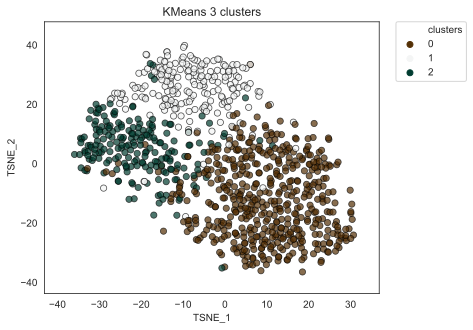

In [36]:
# Plot clustering of clusters
tsne_plot_df = fit_tsne(num_clusters, d2v_vecs_X_train.iloc[:, ~d2v_vecs_X_train.columns.isin(['labels', 'speaker', 'title', 'labels_sub'])],X_train.iloc[:, ~X_train.columns.isin(['labels', 'speaker', 'title'])], assigned_labels = new_labels)
make_tsne_plot(tsne_plot_df, len(set(split_labels)))#, save_name = 'tsne_kmeans_bestreps_sub'+str(len(set(split_labels)))+'232.svg')


# Supervised Classifier

In [40]:
d2v_vecs_X_train2 =  d2v_vecs_X_train.iloc[:, ~d2v_vecs_X_train.columns.isin(['labels_sub','labels', 'speaker','title'])]
                                           

In [41]:
from sklearn.linear_model import LogisticRegression

gs_params = {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
lr = LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
lr.fit(d2v_vecs_X_train2, y_train)
print('Doc2Vec', 'Training set score:',lr.score(d2v_vecs_X_train2, y_train), 'Test set score:', lr.score(d2v_vecs_X_test, y_test) )

y_pred = lr.predict(d2v_vecs_X_test)
pd.crosstab(y_pred, y_test, dropna=False)

Doc2Vec Training set score: 0.73 Test set score: 0.10333333333333333


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


speaker,BRUMFIEL,BURNETT,ELVING,GONZALES,HAMILTON,HARRIS,HORSLEY,JOYCE,KEITH,STEIN
row_0,,,,,,,,,,
BRUMFIEL,1,6,5,3,2,3,5,2,0,4
BURNETT,3,9,1,4,2,1,2,5,0,4
ELVING,3,3,4,4,2,3,5,1,3,2
GONZALES,3,4,2,3,2,6,1,6,5,2
HAMILTON,1,1,2,1,7,2,1,1,2,2
HARRIS,0,3,5,1,2,0,4,2,1,1
HORSLEY,3,2,3,3,3,3,4,10,3,9
JOYCE,5,4,3,8,2,7,1,2,3,4
KEITH,2,2,4,1,2,5,4,0,0,4


In [42]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(d2v_vecs_X_train2, y_train)
print('TFIDF-LSA', 'Training set score:',gbc.score(d2v_vecs_X_train2, y_train), 'Test set score:', gbc.score(d2v_vecs_X_test, y_test) )

y_pred = gbc.predict(d2v_vecs_X_test)
pd.crosstab(y_pred, y_test, dropna=False)

TFIDF-LSA Training set score: 1.0 Test set score: 0.1


speaker,BRUMFIEL,BURNETT,ELVING,GONZALES,HAMILTON,HARRIS,HORSLEY,JOYCE,KEITH,STEIN
row_0,,,,,,,,,,
BRUMFIEL,2,3,4,4,6,3,4,2,1,3
BURNETT,2,6,1,3,1,3,4,5,1,3
ELVING,3,1,4,4,2,3,4,0,2,2
GONZALES,3,4,4,2,2,6,0,6,5,2
HAMILTON,1,1,4,3,3,1,1,2,2,1
HARRIS,2,6,4,2,3,4,4,2,0,2
HORSLEY,2,3,2,4,2,2,3,7,2,7
JOYCE,3,5,2,6,1,2,4,3,2,5
KEITH,4,4,4,2,4,5,3,4,1,6


In [43]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(d2v_vecs_X_train2, y_train)
print('Doc2Vec', 'Training set score:',svc.score(d2v_vecs_X_train2, y_train), 'Test set score:', svc.score(d2v_vecs_X_test, y_test) )

y_pred = svc.predict(d2v_vecs_X_test)
pd.crosstab(y_pred, y_test, dropna=False)

Doc2Vec Training set score: 1.0 Test set score: 0.1


/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


speaker,BRUMFIEL,BURNETT,ELVING,GONZALES,HAMILTON,HARRIS,HORSLEY,JOYCE,KEITH,STEIN
row_0,,,,,,,,,,
BRUMFIEL,2,3,4,4,6,3,4,2,1,3
BURNETT,2,6,1,3,1,3,4,5,1,3
ELVING,3,1,4,4,2,3,4,0,2,2
GONZALES,3,4,4,2,2,6,0,6,5,2
HAMILTON,1,1,4,3,3,1,1,2,2,1
HARRIS,2,6,4,2,3,4,4,2,0,2
HORSLEY,2,3,2,4,2,2,3,7,2,7
JOYCE,3,5,2,6,1,2,4,3,2,5
KEITH,4,4,4,2,4,5,3,4,1,6
